In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import bode, TransferFunction
import os, sys
%matplotlib widget

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tools


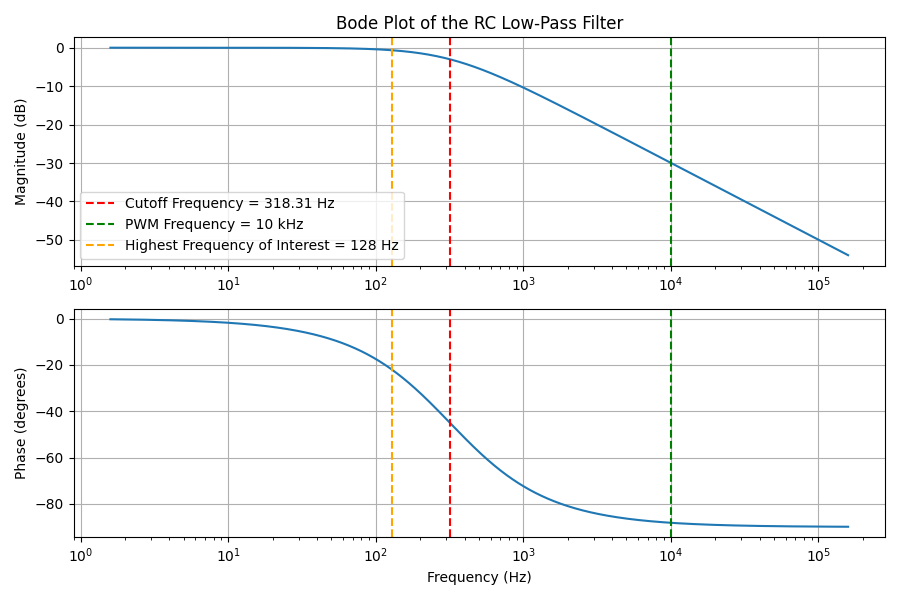

In [5]:
def rc_low_pass_bode(R, C):
    # Calculate the cutoff frequency
    cutoff_frequency = 1 / (2 * np.pi * R * C)
    
    # Create the transfer function H(s) = 1 / (RCs + 1)
    # s = jw, where w is the frequency in radians per second
    num = [1]  # Numerator: 1
    den = [R * C, 1]  # Denominator: RCs + 1
    system = TransferFunction(num, den)
    
    # Generate Bode plot data
    frequencies = np.logspace(1, 6, 1000)  # Frequency range from 10^1 to 10^6 Hz
    w, mag, phase = bode(system, frequencies)
    
    # Convert w to Hz
    freqs = w / (2 * np.pi)
    
    # Create subplots
    fig, ax = plt.subplots(2, 1, figsize=(9, 6))
    
    # Plot magnitude
    ax[0].semilogx(freqs, mag)  # Bode magnitude plot
    ax[0].axvline(x=cutoff_frequency, color='red', linestyle='--', label=f'Cutoff Frequency = {cutoff_frequency:.2f} Hz')
    ax[0].set_title('Bode Plot of the RC Low-Pass Filter')
    ax[0].set_ylabel('Magnitude (dB)')
    ax[0].grid(True)
    
    
    
    # Plot phase
    ax[1].semilogx(freqs, phase)  # Bode phase plot
    ax[1].axvline(x=cutoff_frequency, color='red', linestyle='--')
    ax[1].set_ylabel('Phase (degrees)')
    ax[1].set_xlabel('Frequency (Hz)')
    ax[1].grid(True)
    
    
    ax[0].axvline(x = 10000, color='green', linestyle='--', label=f'PWM Frequency = 10 kHz')
    ax[1].axvline(x = 10000, color='green', linestyle='--')
    ax[0].axvline(x = 128, color='orange', linestyle='--', label=f'Highest Frequency of Interest = 128 Hz')
    ax[1].axvline(x = 128, color='orange', linestyle='--')
    
    ax[0].legend()
    
    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

# Example usage:
R = 50e3  # Resistance in ohms
C = 10e-9  # Capacitance in farads

rc_low_pass_bode(R, C)


In [ ]:
def generate_pwm_signal(frequency, duty_cycle, sample_rate, duration, resolution):
    # Calculate period and samples
    period = 1 / frequency
    period_samples = int(sample_rate * period)
    
    # Calculate the number of samples per PWM level
    level_samples = period_samples / resolution
    
    # Calculate the number of samples for the duty cycle
    duty_cycle_samples = int((duty_cycle) * period_samples)

    # Generate the PWM signal
    pwm_signal = np.zeros(int(sample_rate * duration))
    for i in range(0, len(pwm_signal), period_samples):
        for level in range(resolution):
            start = i + int(level * level_samples)
            end = i + int((level + 1) * level_samples)
            if start < len(pwm_signal):
                pwm_signal[start:end] = 1 if (level + 1) * level_samples <= duty_cycle_samples else 0
    
    return pwm_signal



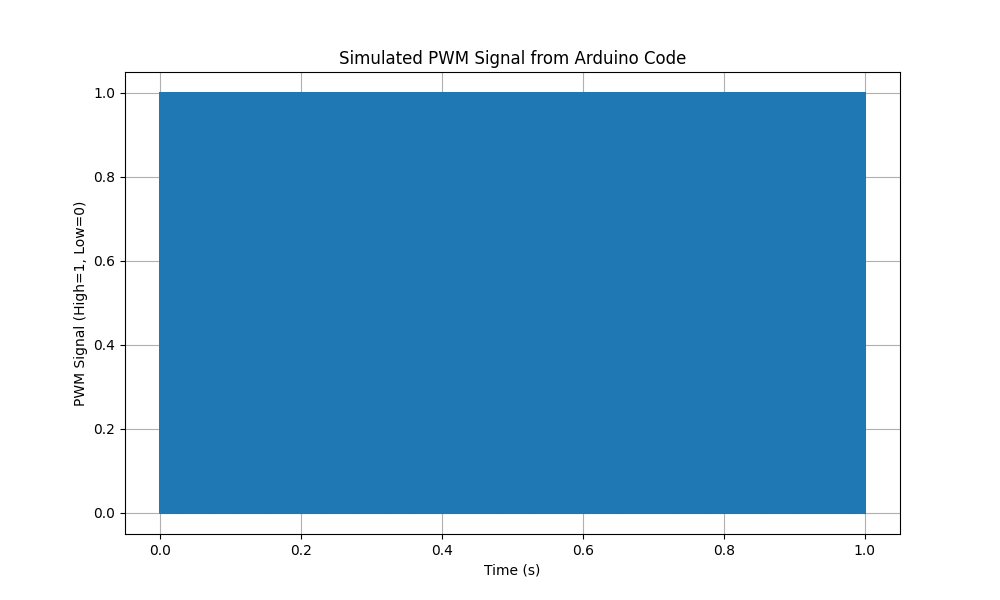

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Constants and parameters
PI = np.pi
freq = 10000  # PWM frequency in Hz
resolution = 12
max_amp = 2**resolution - 1

frequency = 64  # Modulation frequency in Hz
offset_fact = 0.5  # Offset as a fraction of max intensity
amp_fact = 0.2  # Amplitude of modulation as a fraction of max intensity
max_time = 1  # Shorter experiment time in seconds for detailed PWM signal visualization

# Generate the time vector
sampling_rate = 100000  # 100 kHz sampling rate for high resolution

# Data for plotting
pwm_signal = np.array([])

max_time_ms = max_time * 1000  # Convert max_time to milliseconds
time_ms = 0  # Initialize time in milliseconds

# Simulation loop to generate PWM signal
while time_ms < max_time_ms:
    # Calculate the modulated PWM value based on the sinusoidal modulation
    t = time_ms / 1000  # Convert time to seconds
    duty_cycle = amp_fact * np.sin(2 * PI * frequency * t) + offset_fact
    time_ms +=1
    pwm_signal = np.append(pwm_signal, generate_pwm_signal(freq, duty_cycle, sampling_rate, 0.001, 2**resolution))
    
    
    


# Plot the PWM signal
fig, ax = plt.subplots(figsize=(10, 6))

# Define the time vector
time = np.linspace(0, max_time, len(pwm_signal))

# Plot the PWM signal
ax.plot(time, pwm_signal, label=f'PWM Signal (Frequency: {frequency} Hz, Amplitude Factor: {amp_fact})')

# Set titles and labels
ax.set_title('Simulated PWM Signal from Arduino Code')
ax.set_xlabel('Time (s)')
ax.set_ylabel('PWM Signal (High=1, Low=0)')

# Add a grid
ax.grid(True)

# Show the plot
plt.show()


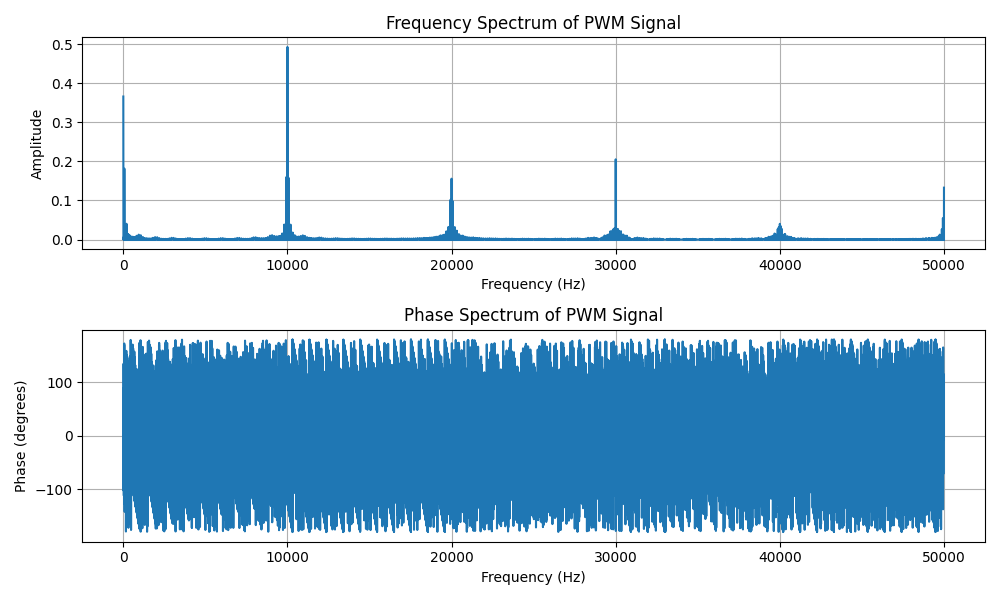

In [47]:
import tools

F, A, P = tools.FFT(time, pwm_signal)
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(F, A)
ax[0].set_title('Frequency Spectrum of PWM Signal')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Amplitude')
ax[0].grid(True)

ax[1].plot(F, P)
ax[1].set_title('Phase Spectrum of PWM Signal')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Phase (degrees)')
ax[1].grid(True)

fig.tight_layout()

In [51]:
def apply_low_pass_filter(signal, sample_rate, R, C):
    from scipy.fft import fft, ifft, fftfreq

    # Calculate the FFT of the input signal
    signal_fft = fft(signal)
    
    # Frequency vector corresponding to the FFT
    frequencies = fftfreq(len(signal), 1/sample_rate)
    
    # Transfer function of the RC low-pass filter
    H_f = 1 / (1 + 1j * 2 * np.pi * frequencies * R * C)
    
    # Apply the filter in the frequency domain
    filtered_signal_fft = signal_fft * H_f
    
    # Convert the filtered signal back to the time domain
    filtered_signal = ifft(filtered_signal_fft)
    
    # Return the real part of the inverse FFT (filtered signal)
    return np.real(filtered_signal)

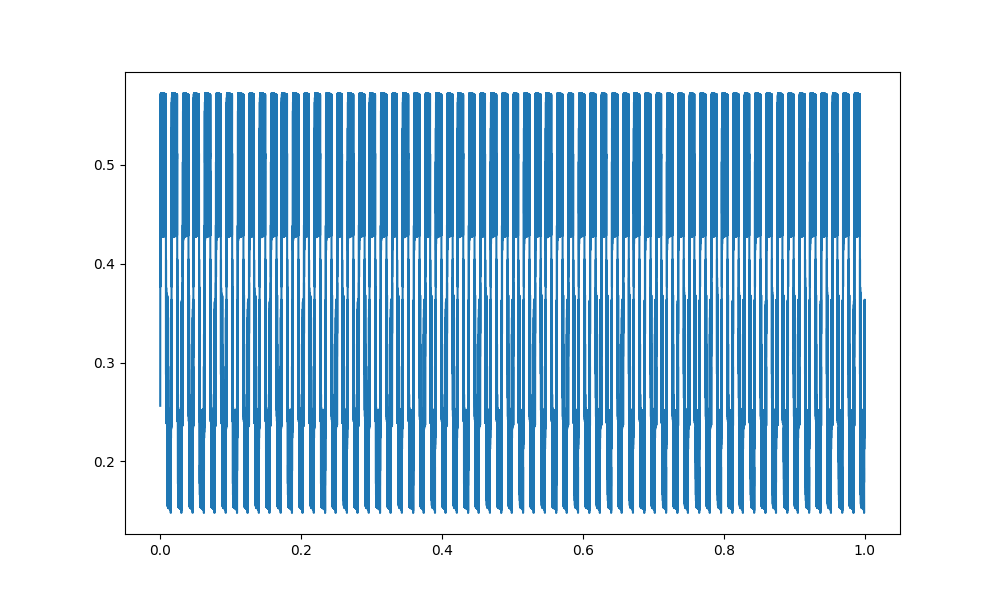

In [49]:
filtered_signal = apply_low_pass_filter(pwm_signal, sampling_rate, R, C)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time, filtered_signal, label='Filtered PWM Signal')